## Create and test ion channel model

In [67]:
from channels.icat_markov import (protocols,
                                  observations,
                                  simulations,
                                  times,
                                  summary_statistics)

In [68]:
from functools import wraps

def simulate_model(**pars):
    """Wrapper function around simulations."""
    data = []
    for sim, time in zip(simulations, times):
        for p, v in pars.items():
            try:
                sim.set_constant(p, v)
            except:
                raise RuntimeWarning('Could not set value of {}'.format(p))
                return None
        sim.reset()
        try:
            data.append(sim.run(time, log=['environment.time','icat.i_CaT','icat.g','icat.a','icat.r']))
        except:
            # Failed simulation
            del(data)
            return None
    return data


def log_transform(f):
    @wraps(f)
    def log_transformed(**log_kwargs):
        kwargs = dict([(key[4:], 10**value) if key.startswith("log")
                       else (key, value)
                       for key, value in log_kwargs.items()])
        return f(**kwargs)
    return log_transformed

def log_model(x):
    return log_transform(simulate_model)(**x)

In [69]:
test = simulate_model()

In [70]:
ss = summary_statistics(test)

In [71]:
assert(len(ss)==len(observations))

## Set limits and generate uniform initial priors

In [79]:
from pyabc import Distribution, RV
limits = {'icat.g_CaT': (0., 2.),
          'icat.E_Ca_offset': (0., 200.), # accounts for reversal potential difference from Nernst 
          'log_icat.p_1': (-50., 50.),
          'icat.p_2': (0., 1.),
          'log_icat.p_3': (-50., 50.),
          'icat.p_4': (0., 2.), # increased as clustering at boundary
          'log_icat.p_5': (-50., 50.),
          'icat.p_6': (0., 1.),
          'log_icat.p_7': (-50., 50.),
          'icat.p_8': (0., 1.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [80]:
test = log_model(prior.rvs())

## Run ABC calibration

In [81]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat_markov.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat_markov.db


In [82]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [83]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [84]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=log_model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.01),
             population_size=ConstantPopulationSize(5000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=10000,
             #    mean_cv=0.4,
             #    max_population_size=30000,
             #    min_population_size=pop_size),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 2.042662507755895, '1': 2.042662507755895, '2': 1.3175173175025499, '3': 1.5057340771457712, '4': 0.8107798876938791, '5': 0.34000446903291687, '6': 0.19518775074111877, '7': 0.16468966468781915, '8': 0.16468966468781915, '9': 0.16468966468781915, '10': 0.16215597753877592, '11': 0.17000223451645843, '12': 0.1882167596432214, '13': 0.1756689756670071, '14': 0.1988705384909512, '15': 0.2291334465221833, '16': 0.2509556795242961, '17': 0.2702599625646261, '18': 0.34000446903291687, '19': 0.3634530531041516, '20': 0.45826689304436596, '21': 0.5019113590485913, '22': 0.4582668930443666, '23': 1.219705208958084, '24': 1.3213473097046027, '25': 1.132583408318225, '26': 2.3490618839192794, '27': 2.3490618839192794, '28': 0.8345351429713199, '29': 0.5285389238818384, '30': 0.4285450734177068, '31': 0.46635787401338613, '32': 0.5662917041591125, '33': 0.7928083858227557, '34': 1.0570778477636744, '35': 1.5856167716455234, '36': 1.5856167716455114, '37': 2.34

In [85]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [86]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=3, start_time=2019-06-19 20:19:14.021058, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.0, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: invalid value encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_

/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 269792
DEBUG:Epsilon:new eps, t=5, eps=6.999444862151512
INFO:ABC:t:5 eps:6.999444862151512
DEBUG:ABC:now submi

In [ ]:
history = abc.run(minimum_epsilon=0.0, max_nr_populations=100, min_acceptance_rate=0.001)

# Results analysis

In [88]:
from pyabc import History

In [92]:
history = History('sqlite:////scratch/cph211/tmp/hl-1_icat_markov.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2019-06-16 17:37:10.210410, end_time=2019-06-17 10:50:52.101144)>,
 <ABCSMC(id=2, start_time=2019-06-17 14:59:07.788964, end_time=2019-06-17 21:16:15.099165)>,
 <ABCSMC(id=3, start_time=2019-06-19 20:19:14.021058, end_time=None)>]

In [93]:
history.id = 3

In [94]:
df, w = history.get_distribution(m=0)

In [95]:
df.describe()

name,icat.E_Ca_offset,icat.g_CaT,icat.p_2,icat.p_4,icat.p_6,icat.p_8,log_icat.p_1,log_icat.p_3,log_icat.p_5,log_icat.p_7
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,105.340342,0.253109,0.386006,1.458863,0.186703,0.044524,4.698916,-48.554517,1.280648,-3.609294
std,0.161838,0.001762,0.001529,0.032763,0.001276,0.001255,0.038520,1.061409,0.033708,0.043202
min,104.829239,0.247162,0.380025,1.341848,0.182390,0.040852,4.562817,-49.999823,1.173617,-3.734886
25%,105.226005,0.251921,0.384956,1.437012,0.185799,0.043617,4.671999,-49.436665,1.257469,-3.640235
50%,105.331515,0.253105,0.385996,1.464554,0.186711,0.044529,4.699589,-48.745777,1.280516,-3.609369
75%,105.458169,0.254334,0.387085,1.486202,0.187584,0.045432,4.726507,-47.854942,1.304777,-3.578205
max,105.731462,0.259585,0.390749,1.505097,0.190656,0.048269,4.820500,-44.750226,1.380588,-3.481513


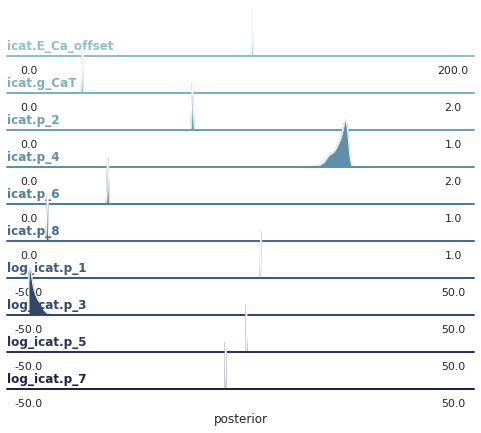

In [96]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

In [97]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [98]:
plotting_obs = observations.copy()

In [99]:
plotting_obs.rename({'exp_id': 'exp', 'variance': 'errs'}, axis=1, inplace=True)

In [100]:
import numpy as np
plotting_obs['errs'] = np.sqrt(plotting_obs['errs'])

In [101]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(log_model(th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp': plotting_obs.exp})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

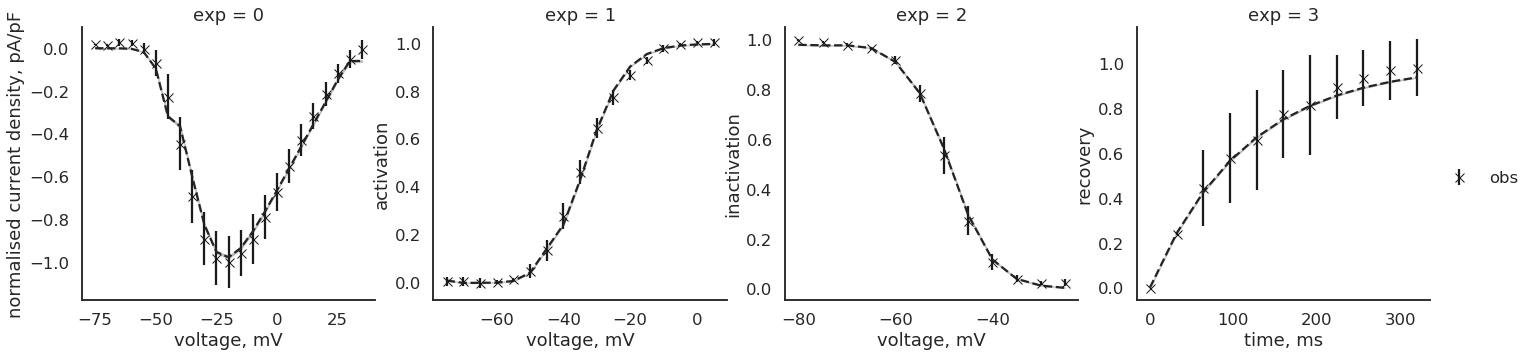

In [102]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=plotting_obs)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]#, "time, ms","voltage, mV"]
ylabels = ["normalised current density, pA/pF", "activation", "inactivation", "recovery"]#, "normalised current","current density, pA/pF"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [103]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

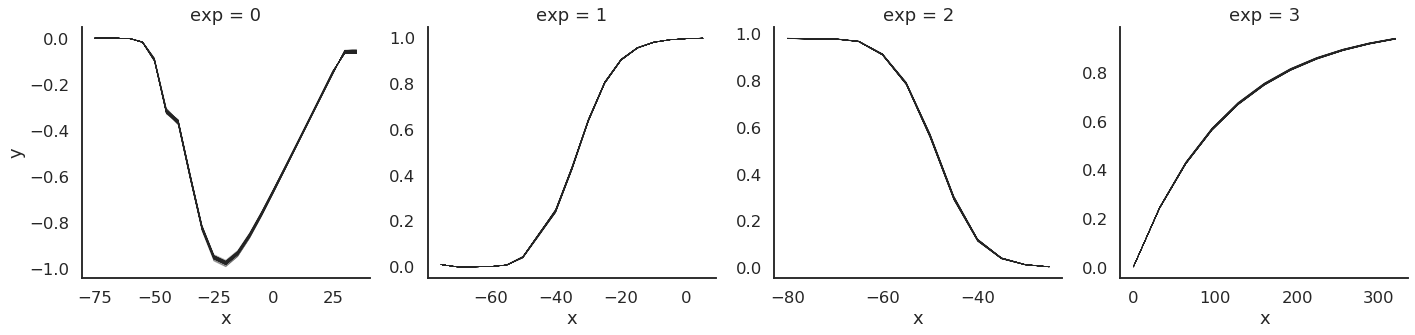

In [104]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
